In [82]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans , DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import hdbscan
import seaborn as sns
warnings.filterwarnings('ignore')

# 1.1 Data Preparation & Exploratory Analysis

Loading the data set

In [2]:
df = pd.read_excel('data.xlsx')
df.head()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,2017-01-01 00:00:00,1056.46,1096.03,-456.66,-459.31,992.24,-396.37
1,2017-01-01 00:05:00,974.1,1036.63,-437.96,-432.07,941.36,-391.08
2,2017-01-01 00:10:00,931.39,1011.47,-414.06,-404.83,979.89,-348.66
3,2017-01-01 00:15:00,969.06,896.65,-401.6,-381.7,888.22,-336.56
4,2017-01-01 00:20:00,874.87,841.38,-401.52,-352.72,923.94,-345.53


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377719 entries, 0 to 377718
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   time                      377719 non-null  datetime64[ns]
 1   Cyclone_Inlet_Gas_Temp    377719 non-null  object        
 2   Cyclone_Material_Temp     377719 non-null  object        
 3   Cyclone_Outlet_Gas_draft  377719 non-null  object        
 4   Cyclone_cone_draft        377719 non-null  object        
 5   Cyclone_Gas_Outlet_Temp   377719 non-null  object        
 6   Cyclone_Inlet_Draft       377719 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 20.2+ MB


Changing the dtype from object to datetime and float

In [4]:
df['time'] = pd.to_datetime(df['time'])

In [5]:
for col in df.columns:
    if df[col].dtype == 'object' and df[col] is not "time":
        df[col] = pd.to_numeric(df[col], errors = 'coerce')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377719 entries, 0 to 377718
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   time                      377719 non-null  datetime64[ns]
 1   Cyclone_Inlet_Gas_Temp    376399 non-null  float64       
 2   Cyclone_Material_Temp     376128 non-null  float64       
 3   Cyclone_Outlet_Gas_draft  376398 non-null  float64       
 4   Cyclone_cone_draft        376399 non-null  float64       
 5   Cyclone_Gas_Outlet_Temp   376398 non-null  float64       
 6   Cyclone_Inlet_Draft       376397 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 20.2 MB


Checking for strict 5 min indexing


In [7]:
df = df.sort_values('time')

In [8]:
time_interval = pd.date_range(start = df['time'].iloc[0], periods = len(df), freq = "5T") # 5 minutes
df['time']=time_interval

Description : We have handled those values that did not satisfy the 5-min indexing 

Checking for null values

In [9]:
df.isnull().sum()

time                           0
Cyclone_Inlet_Gas_Temp      1320
Cyclone_Material_Temp       1591
Cyclone_Outlet_Gas_draft    1321
Cyclone_cone_draft          1320
Cyclone_Gas_Outlet_Temp     1321
Cyclone_Inlet_Draft         1322
dtype: int64

Handling the null values 

In [10]:
df = df.bfill().ffill()

In [11]:
df.isnull().sum()

time                        0
Cyclone_Inlet_Gas_Temp      0
Cyclone_Material_Temp       0
Cyclone_Outlet_Gas_draft    0
Cyclone_cone_draft          0
Cyclone_Gas_Outlet_Temp     0
Cyclone_Inlet_Draft         0
dtype: int64

Description : Now all the null values has been handled and ensured strict 5-min indexing too.

Summary statistics and correlation matrix

In [12]:
summary = df.describe()
summary

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,377719,377719.000000,377719.000000,377719.000000,377719.000000,377719.000000,377719.000000
mean,2018-10-18 18:14:59.999999232,727.837842,751.331014,-177.057954,-164.749929,716.309102,-141.434417
min,2017-01-01 00:00:00,0.000000,-185.000000,-456.660000,-459.310000,13.790000,-396.370000
25%,2017-11-24 21:07:30,856.490000,867.990000,-247.080000,-226.670000,803.590000,-193.400000
50%,2018-10-18 18:15:00,882.250000,913.110000,-214.980000,-198.760000,871.760000,-169.590000
75%,2019-09-11 15:22:30,901.040000,943.530000,-168.575000,-144.440000,899.190000,-136.690000
max,2020-08-04 12:30:00,1157.630000,1375.000000,40.270000,488.860000,1375.000000,41.640000
std,NaN,328.194044,350.433460,99.807607,89.995266,324.909279,77.511967


In [13]:
correlation = df.corr()

Plotting the correlation matrix as heatmap                           

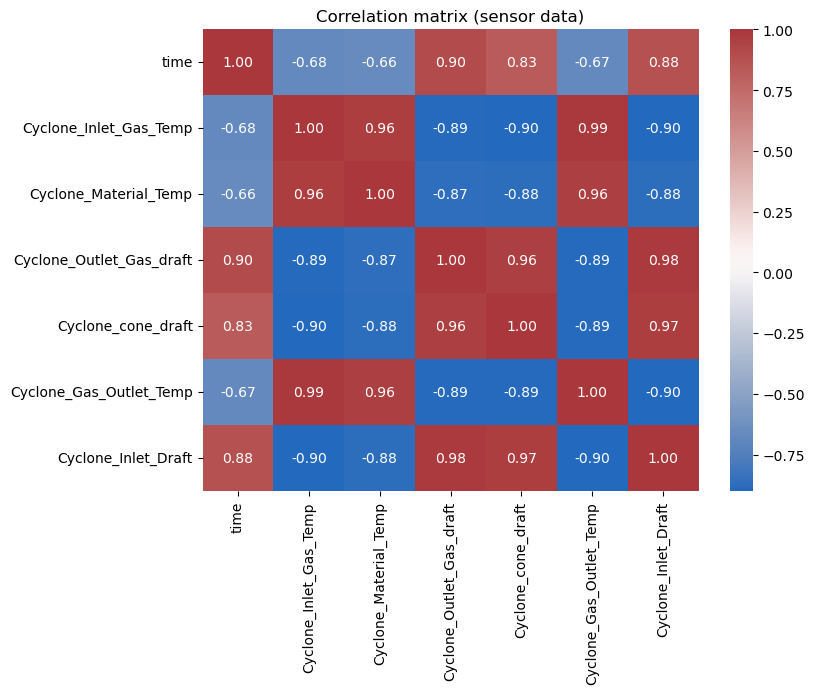

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='vlag')
plt.title("Correlation matrix (sensor data)")
plt.show()

Description : We can see that Cyclone_Inlet_Gas_Temp is highly positively correlated with Cyclone_Material_temp and Cyclone_Gas_outlet_temp but is inversly correlated with Cyclone_inlet_draft , Cyclone_outlet_gas_draft and Cyclone_cone_draft 

Visualization of Representative slices (one week and one year)

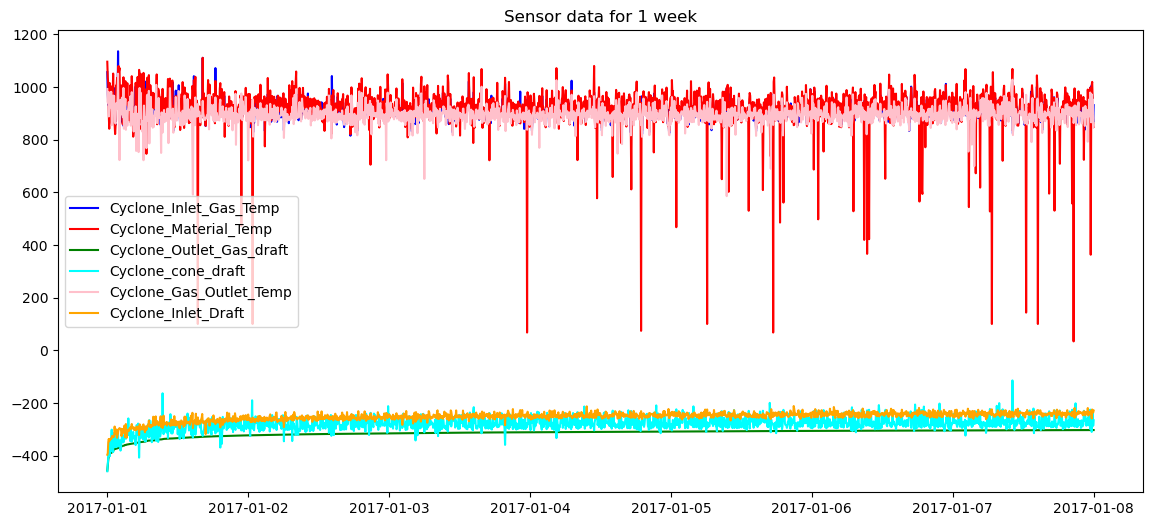

In [15]:
# Week Slice Visualtion
df = df.set_index('time')
start_date = df.index.min()+pd.Timedelta(days=0)
end_date = start_date+pd.Timedelta(days=7)

plt.figure(figsize=(14,6))
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Inlet_Gas_Temp'], label='Cyclone_Inlet_Gas_Temp', color="blue")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Material_Temp'], label='Cyclone_Material_Temp', color="red")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Outlet_Gas_draft'], label='Cyclone_Outlet_Gas_draft', color="green")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_cone_draft'], label='Cyclone_cone_draft', color="cyan")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Gas_Outlet_Temp'], label='Cyclone_Gas_Outlet_Temp', color="pink")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Inlet_Draft'], label='Cyclone_Inlet_Draft', color="orange")
plt.title('Sensor data for 1 week')
plt.legend()
plt.show()




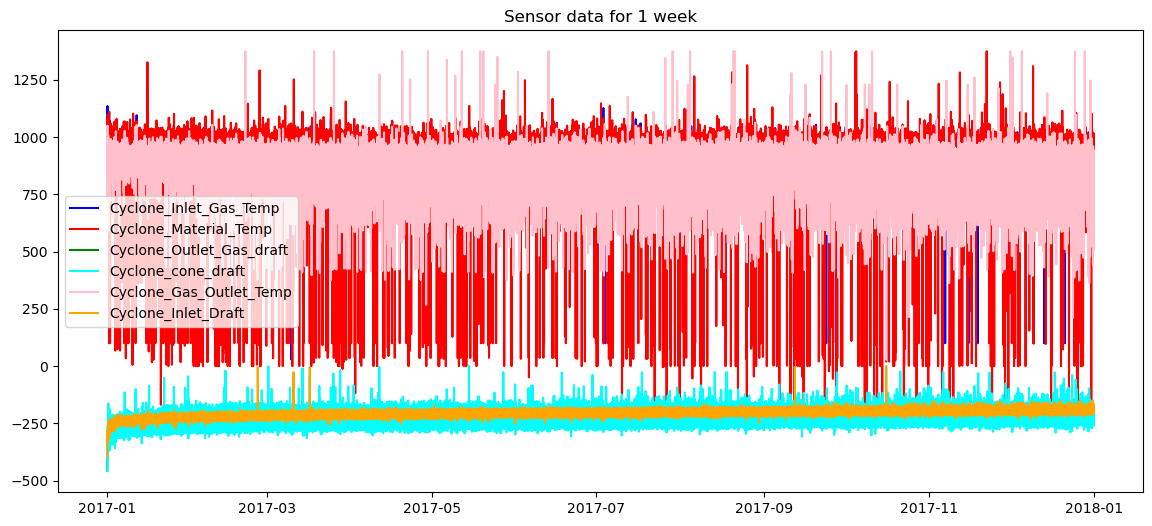

In [16]:
# Year Slice Visualtion
start_date = df.index.min()+pd.Timedelta(days=0)
end_date = start_date+pd.Timedelta(days=365)


plt.figure(figsize=(14,6))
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Inlet_Gas_Temp'], label='Cyclone_Inlet_Gas_Temp', color="blue")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Material_Temp'], label='Cyclone_Material_Temp', color="red")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Outlet_Gas_draft'], label='Cyclone_Outlet_Gas_draft', color="green")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_cone_draft'], label='Cyclone_cone_draft', color="cyan")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Gas_Outlet_Temp'], label='Cyclone_Gas_Outlet_Temp', color="pink")
plt.plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date]['Cyclone_Inlet_Draft'], label='Cyclone_Inlet_Draft', color="orange")
plt.title('Sensor data for 1 week')
plt.legend()
plt.show()


# 1.2 Shutdown/ Idle Period Detection

From the given information we assume that if the Cyclone_Inlet_Gas_Temp is lower then it leads to the conclusion of a shutdown or idle condition. For that we need to determine a threshold value for classification.

We would find the threshold value by plotting a histogram for the feature Cyclone_Inlet_Gas_Temp

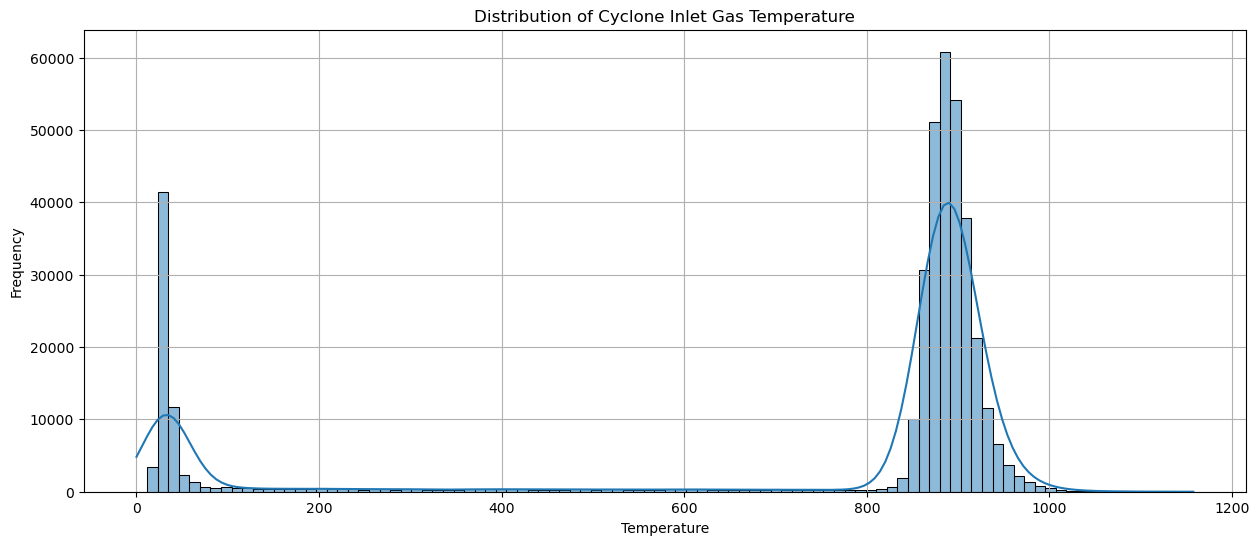

In [17]:
plt.figure(figsize=(15, 6))
sns.histplot(df['Cyclone_Inlet_Gas_Temp'], bins=100, kde=True)
plt.title('Distribution of Cyclone Inlet Gas Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the above histogram we can see the left side peak or the shutdown peak represents the time when the machine is shutdown or idle and the right peak denotes the operational peak when the machine is in the running state. So we would choose a point such as **150** since it is in the middle of the two peaks and can be considered as a threshold

Now create a new column to classify the temp values based on the threshold

In [18]:
threshold = 150
df['shutdown_or_idle'] = df['Cyclone_Inlet_Gas_Temp'] < threshold

Now we need to find the intervals that changes from False to True and True to False in the **shutdown_or_idle column**

In [19]:
df['shutdown_diff'] = df['shutdown_or_idle'].astype(int).diff()

Now for the starting and ending of shutdown we see that if the difference is 1 then it is the start of the shutdown and if the difference is -1 then it is the end of the shutdown

In [20]:
shutdown_start = df[df['shutdown_diff'] == 1].index
shutdown_end = df[df['shutdown_diff'] == -1].index

Now we extract the indexes of the duration from the shutdown start to shutdown end timestamp

In [21]:
if df['shutdown_or_idle'].iloc[0]:
    shutdown_start = pd.to_datetime([df.index[0]]).union(shutdown_start)
if df['shutdown_or_idle'].iloc[-1]:
    shutdown_end = shutdown_end.union(pd.to_datetime([df.index[-1]]))

Now we create a data frame that takes the indexes (timestamps) of the shutdown start and end index and then we create a new column called **'duration'** that captures the duration of each shutdown

In [22]:
if len(shutdown_start) > 0 and len(shutdown_end) > 0:
    if shutdown_end[0] < shutdown_start[0]:
        shutdown_end = shutdown_end[1:]
    if shutdown_start[-1] > shutdown_end[-1]:
        shutdown_start = shutdown_start[:-1]
    shutdown_periods = pd.DataFrame({
        'start_time': shutdown_start[:len(shutdown_end)],
        'end_time': shutdown_end[:len(shutdown_start)]
    })
    shutdown_periods['duration'] = shutdown_periods['end_time'] - shutdown_periods['start_time']
else:
    shutdown_periods = pd.DataFrame(columns=['start_time', 'end_time', 'duration'])

We sum up the duration to obtain the total shutdown time and the len of the shutdown period corresponds to each shutdown occurences.

In [23]:
total_downtime = shutdown_periods['duration'].sum()
num_shutdown_events = len(shutdown_periods)

print(f"--- Shutdown Analysis Results ---")
print(f"Total number of shutdown events detected: {num_shutdown_events}")
print(f"Total downtime across 3 years: {total_downtime}")

--- Shutdown Analysis Results ---
Total number of shutdown events detected: 5567
Total downtime across 3 years: 221 days 08:05:00


Visualization of 1 full year with shutdowns clearly highlighted.

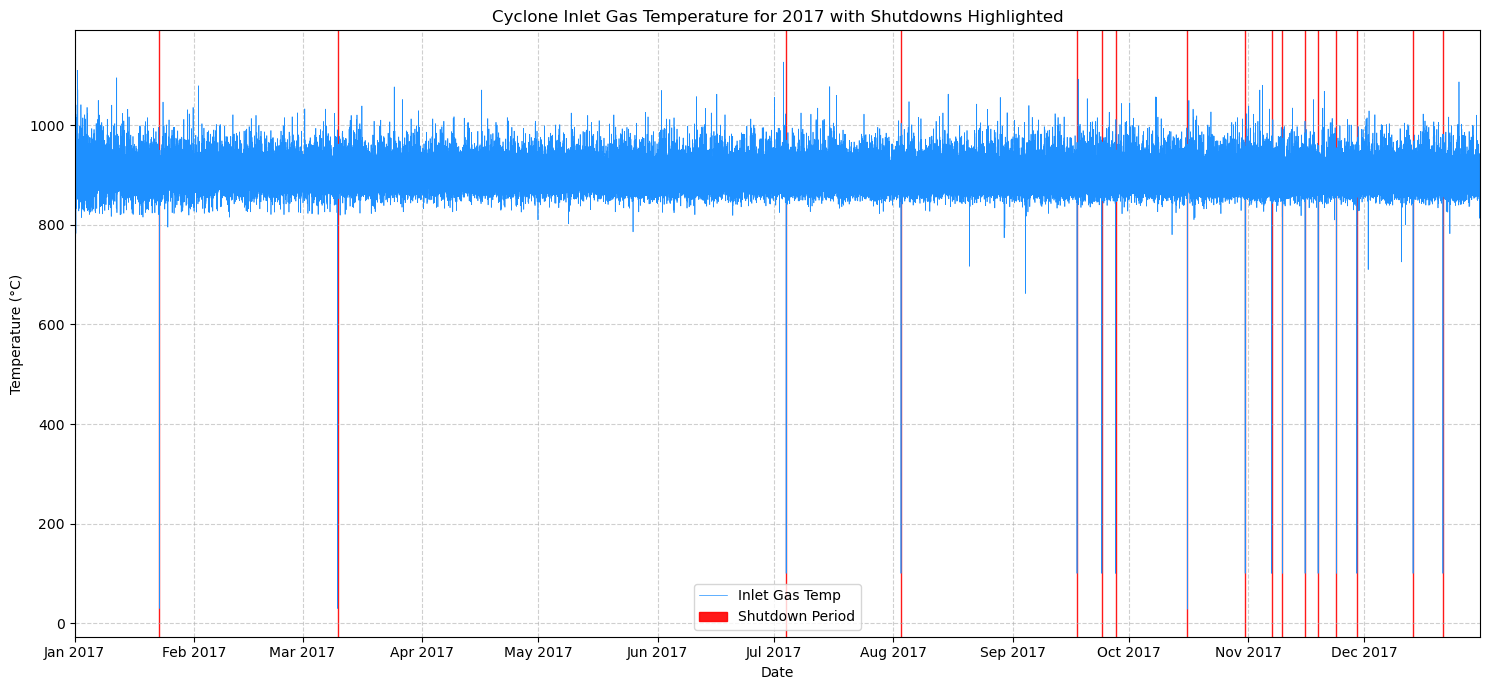

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))

df_year = df.loc['2017']
ax.plot(df_year.index, df_year['Cyclone_Inlet_Gas_Temp'], label='Inlet Gas Temp', color='dodgerblue', linewidth=0.5)

shutdowns_in_2017 = shutdown_periods[shutdown_periods['start_time'].dt.year == 2017]
for _, row in shutdowns_in_2017.iterrows():
    ax.axvspan(row['start_time'], row['end_time'], color='red', alpha=0.9, label='Shutdown Period')

# Manually set the x-axis limits to avoid environment bugs
ax.set_xlim([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-12-31')])

# Formatting the plot
ax.set_title('Cyclone Inlet Gas Temperature for 2017 with Shutdowns Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend(['Inlet Gas Temp', 'Shutdown Period'])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

The above plot is the visualisation of the senosor data for the year 2017 and the Inlet Gas Temp is denoted by the blue color and the machine shutdown that were recorded has been represented in the red color.

# 1.3 Machine State Segmentation (Clustering)

For taking only the active operation periods we would exclude the shutdown_or_idle periods from the original data

In [25]:
df_active = df[~df['shutdown_or_idle']].copy()
print(f"Active rows for clustering : {df_active.shape[0]}")
df_active = df_active.drop(columns=['shutdown_or_idle','shutdown_diff'])

Active rows for clustering : 313974


Now for obtaining a total behaviour of the machine over time we use the rolling-average

For that we will create some features for lags , delta and rolling statistics

We have implemented lag values of 1 and 2 to all the columns

In [26]:
# Lag features
lag_steps=[1,2]

for col in df_active.columns:
    if col != 'time' :
        for lag in lag_steps:
            df_active[f"{col}_lag_{lag}"] = df_active[col].shift(lag)

df_active = df_active.dropna().reset_index()

In [27]:
df_active.head()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,Cyclone_Inlet_Gas_Temp_lag_1,Cyclone_Inlet_Gas_Temp_lag_2,Cyclone_Material_Temp_lag_1,Cyclone_Material_Temp_lag_2,Cyclone_Outlet_Gas_draft_lag_1,Cyclone_Outlet_Gas_draft_lag_2,Cyclone_cone_draft_lag_1,Cyclone_cone_draft_lag_2,Cyclone_Gas_Outlet_Temp_lag_1,Cyclone_Gas_Outlet_Temp_lag_2,Cyclone_Inlet_Draft_lag_1,Cyclone_Inlet_Draft_lag_2
0,2017-01-01 00:10:00,931.39,1011.47,-414.06,-404.83,979.89,-348.66,974.10,1056.46,1036.63,1096.03,-437.96,-456.66,-432.07,-459.31,941.36,992.24,-391.08,-396.37
1,2017-01-01 00:15:00,969.06,896.65,-401.60,-381.70,888.22,-336.56,931.39,974.10,1011.47,1036.63,-414.06,-437.96,-404.83,-432.07,979.89,941.36,-348.66,-391.08
2,2017-01-01 00:20:00,874.87,841.38,-401.52,-352.72,923.94,-345.53,969.06,931.39,896.65,1011.47,-401.60,-414.06,-381.70,-404.83,888.22,979.89,-336.56,-348.66
3,2017-01-01 00:25:00,962.13,1014.91,-392.51,-402.10,933.94,-337.08,874.87,969.06,841.38,896.65,-401.52,-401.60,-352.72,-381.70,923.94,888.22,-345.53,-336.56
4,2017-01-01 00:30:00,988.22,946.20,-391.04,-343.31,980.48,-338.18,962.13,874.87,1014.91,841.38,-392.51,-401.52,-402.10,-352.72,933.94,923.94,-337.08,-345.53


Next we will implement delta for the original features

In [28]:
org_cols = ['Cyclone_Inlet_Gas_Temp','Cyclone_Material_Temp','Cyclone_Outlet_Gas_draft','Cyclone_cone_draft','Cyclone_Gas_Outlet_Temp','Cyclone_Inlet_Draft']

for col in org_cols:
    df_active[f"{col}_delta"] = df_active[col].diff()
    

Now we will implement rolling statistics such as mean and std

In [29]:
for col in org_cols:
    df_active[f"{col}_rolling_mean_1h"] = df_active[col].rolling(window=12).mean()
    df_active[f"{col}_rolling_std_1h"] = df_active[col].rolling(window=12).std()

df_active = df_active.dropna()
# df_active = df_active.drop(columns='level_0')
df_active.head()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,Cyclone_Inlet_Gas_Temp_lag_1,Cyclone_Inlet_Gas_Temp_lag_2,Cyclone_Material_Temp_lag_1,...,Cyclone_Material_Temp_rolling_mean_1h,Cyclone_Material_Temp_rolling_std_1h,Cyclone_Outlet_Gas_draft_rolling_mean_1h,Cyclone_Outlet_Gas_draft_rolling_std_1h,Cyclone_cone_draft_rolling_mean_1h,Cyclone_cone_draft_rolling_std_1h,Cyclone_Gas_Outlet_Temp_rolling_mean_1h,Cyclone_Gas_Outlet_Temp_rolling_std_1h,Cyclone_Inlet_Draft_rolling_mean_1h,Cyclone_Inlet_Draft_rolling_std_1h
11,2017-01-01 01:05:00,942.00,949.08,-378.21,-314.32,958.78,-329.67,998.70,960.76,1051.04,...,951.795833,63.452777,-391.585833,9.898618,-360.764167,33.131376,933.108333,43.651378,-334.917500,7.309039
12,2017-01-01 01:10:00,994.38,937.15,-375.63,-319.81,966.28,-326.25,942.00,998.70,949.08,...,945.602500,60.664510,-388.383333,8.001349,-353.679167,31.919855,931.974167,42.486650,-333.050000,6.267239
13,2017-01-01 01:15:00,935.13,860.09,-375.06,-318.68,867.49,-289.46,994.38,942.00,937.15,...,942.555833,64.163615,-386.171667,7.677421,-348.427500,32.074435,930.246667,44.786604,-329.125000,13.931526
14,2017-01-01 01:20:00,910.54,821.21,-375.00,-367.72,865.77,-311.62,935.13,994.38,860.09,...,940.875000,67.245158,-383.961667,6.598873,-349.677500,32.545755,925.399167,48.523403,-326.299167,13.739256
15,2017-01-01 01:25:00,857.19,855.33,-374.11,-361.44,861.08,-316.35,910.54,935.13,821.21,...,927.576667,67.051976,-382.428333,6.569657,-346.289167,28.450845,919.327500,51.805014,-324.571667,13.562606


Now clustering using the original and the newly generated features

In [30]:
features =  [col for col in df_active.columns if col != 'time']

In [31]:
X = df_active[features].values

Scaling the data for limiting it between 0 and 1

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Implementing K-Means Clustering

In [33]:
k_means = KMeans(n_clusters=3,random_state=42)
df_active["kmeans_cluster"] = k_means.fit_predict(X_scaled)

Implementing DBSCAN

In [34]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
df_active["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

Implementing HDBSCAN

In [35]:
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
df_active["hdbscan_cluster"] = hdb.fit_predict(X_scaled)

Summary Statistic for Clustering

In [36]:
cluster_col = "kmeans_cluster"   
time_col = "time"                

In [37]:
summary_stats = df_active.groupby(cluster_col)[org_cols].agg(
    ["mean", "std", "min", "max", lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]
)

In [38]:
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
print("\n=== Summary Statistics per Cluster ===")
print(summary_stats)


=== Summary Statistics per Cluster ===
                Cyclone_Inlet_Gas_Temp_mean  Cyclone_Inlet_Gas_Temp_std  \
kmeans_cluster                                                            
0                                887.438989                   28.187738   
1                                459.020111                  199.565898   
2                                897.308207                   24.605195   

                Cyclone_Inlet_Gas_Temp_min  Cyclone_Inlet_Gas_Temp_max  \
kmeans_cluster                                                           
0                                   220.45                     1157.63   
1                                   150.03                     1081.03   
2                                   662.40                     1135.63   

                Cyclone_Inlet_Gas_Temp_<lambda_0>  \
kmeans_cluster                                      
0                                        870.8300   
1                                        284.7225   
2

In [39]:
freq = df_active[cluster_col].value_counts(normalize=True) * 100
print("\n=== Frequency of Each State (%) ===")
print(freq)


=== Frequency of Each State (%) ===
kmeans_cluster
2    49.468246
0    44.871815
1     5.659939
Name: proportion, dtype: float64


**Description** : We can see that there is a a slight higher chance for the Degraded (2) state than the Normal state

In [40]:
df_active["state_change"] = (df_active[cluster_col] != df_active[cluster_col].shift()).cumsum()
durations = df_active.groupby([cluster_col, "state_change"]).agg(
    start_time=(time_col, "first"),
    end_time=(time_col, "last"),
    duration=("time", lambda x: (x.max() - x.min()).total_seconds() / 3600)  # duration in hours
).reset_index(drop=True)

In [41]:
print("\n=== Duration of Each Consecutive State ===")
print(durations.head())


=== Duration of Each Consecutive State ===
           start_time            end_time  duration
0 2017-11-06 02:05:00 2017-11-06 02:05:00  0.000000
1 2017-11-15 05:50:00 2017-11-15 05:50:00  0.000000
2 2017-11-27 06:00:00 2017-11-27 06:00:00  0.000000
3 2017-12-04 01:30:00 2017-12-04 01:35:00  0.083333
4 2017-12-08 01:55:00 2017-12-08 02:05:00  0.166667


In [42]:
cluster_labels = {
    0: "Normal",
    1: "High Load ",
    2: "Degraded"
}

df_active["state_label"] = df_active[cluster_col].map(cluster_labels)

print("\n=== Data with Interpretable States ===")
print(df_active[[time_col, cluster_col, "state_label"]].head())


=== Data with Interpretable States ===
                  time  kmeans_cluster state_label
11 2017-01-01 01:05:00               2    Degraded
12 2017-01-01 01:10:00               2    Degraded
13 2017-01-01 01:15:00               2    Degraded
14 2017-01-01 01:20:00               2    Degraded
15 2017-01-01 01:25:00               2    Degraded


# 1.4 Contextual Anomaly Detection + Root Cause Analysis

Cluster Anomaly Detection 

In [43]:
df_active.head()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,Cyclone_Inlet_Gas_Temp_lag_1,Cyclone_Inlet_Gas_Temp_lag_2,Cyclone_Material_Temp_lag_1,...,Cyclone_cone_draft_rolling_std_1h,Cyclone_Gas_Outlet_Temp_rolling_mean_1h,Cyclone_Gas_Outlet_Temp_rolling_std_1h,Cyclone_Inlet_Draft_rolling_mean_1h,Cyclone_Inlet_Draft_rolling_std_1h,kmeans_cluster,dbscan_cluster,hdbscan_cluster,state_change,state_label
11,2017-01-01 01:05:00,942.00,949.08,-378.21,-314.32,958.78,-329.67,998.70,960.76,1051.04,...,33.131376,933.108333,43.651378,-334.917500,7.309039,2,-1,-1,1,Degraded
12,2017-01-01 01:10:00,994.38,937.15,-375.63,-319.81,966.28,-326.25,942.00,998.70,949.08,...,31.919855,931.974167,42.486650,-333.050000,6.267239,2,-1,-1,1,Degraded
13,2017-01-01 01:15:00,935.13,860.09,-375.06,-318.68,867.49,-289.46,994.38,942.00,937.15,...,32.074435,930.246667,44.786604,-329.125000,13.931526,2,-1,-1,1,Degraded
14,2017-01-01 01:20:00,910.54,821.21,-375.00,-367.72,865.77,-311.62,935.13,994.38,860.09,...,32.545755,925.399167,48.523403,-326.299167,13.739256,2,-1,-1,1,Degraded
15,2017-01-01 01:25:00,857.19,855.33,-374.11,-361.44,861.08,-316.35,910.54,935.13,821.21,...,28.450845,919.327500,51.805014,-324.571667,13.562606,2,-1,-1,1,Degraded


In [44]:
anomaly_results = pd.DataFrame()

for state in df_active["state_label"].unique():
    df_state = df_active[df_active["state_label"] == state].copy()
    
    # Features for anomaly detection
    X_state = df_state[org_cols].values
    
    # Train Isolation Forest per cluster/state
    iso = IsolationForest(contamination=0.01, random_state=42)
    df_state['anomaly_score'] = iso.fit_predict(X_state)
    
    # Mark anomalies: -1 means anomaly
    df_state['anomaly'] = df_state['anomaly_score'] == -1
    
    anomaly_results = pd.concat([anomaly_results, df_state], axis=0)

# Sort by datetime
anomaly_results = anomaly_results.sort_values("time").reset_index(drop=True)

Now group the consecutive anomalies into events and finding its start, stop , duration, most implicated variables

In [50]:
print(anomaly_results["event_change"].head())
print(anomaly_results["event_change"].apply(type).value_counts())


0    1
1    1
2    1
3    1
4    1
Name: event_change, dtype: int32
event_change
<class 'int'>    313961
Name: count, dtype: int64


In [52]:
events = (
    anomaly_results[anomaly_results['anomaly']]
    .groupby('event_change')
    .agg(
        start_time=('time', 'first'),
        end_time=('time', 'last'),
        duration=('time', lambda x: (x.max() - x.min()).total_seconds()/3600),  # hours
        state=('state_label', 'first')
    )
    .reset_index()
)

# now compute most implicated variable separately
def most_implicated(group):
    return group[org_cols].std().idxmax()

most_vars = (
    anomaly_results[anomaly_results['anomaly']]
    .groupby('event_change')
    .apply(most_implicated)
    .reset_index(name="most_implicated_var")
)

# merge back
events = events.merge(most_vars, on="event_change", how="left")
print(events)

      event_change          start_time            end_time  duration  \
0                1 2017-01-01 01:05:00 2017-01-01 09:10:00  8.083333   
1                3 2017-01-01 09:20:00 2017-01-01 09:25:00  0.083333   
2                5 2017-01-01 09:35:00 2017-01-01 09:45:00  0.166667   
3                7 2017-01-01 09:55:00 2017-01-01 09:55:00  0.000000   
4                9 2017-01-01 10:05:00 2017-01-01 10:40:00  0.583333   
...            ...                 ...                 ...       ...   
1989          3979 2019-12-08 21:55:00 2019-12-08 22:30:00  0.583333   
1990          3981 2019-12-08 23:20:00 2019-12-09 00:30:00  1.166667   
1991          3983 2019-12-09 00:50:00 2019-12-09 00:50:00  0.000000   
1992          3985 2020-06-16 12:25:00 2020-06-16 12:25:00  0.000000   
1993          3987 2020-07-30 21:50:00 2020-07-30 21:50:00  0.000000   

           state     most_implicated_var  
0       Degraded   Cyclone_Material_Temp  
1       Degraded      Cyclone_cone_draft  
2     

Proposing a root casuse analysis of the basis of the data

In [53]:
def root_cause_analysis(events, df, features, cluster_col="state_label", time_col="time"):
    results = []
    
    for idx, row in events.iterrows():
        start, end, state = row["start_time"], row["end_time"], row["state"]
        
        # Subset anomaly period
        anomaly_df = df[(df[time_col] >= start) & (df[time_col] <= end)]
        
        # Subset cluster baseline (same state, non-anomaly)
        baseline_df = df[(df[cluster_col] == state) & (~df["anomaly"])]
        
        event_desc = {"event_id": idx+1, "state": state, "start": start, "end": end, "duration": row["duration"]}
        hypotheses = []
        
        for feature in features:
            # Compare anomaly vs. cluster baseline
            mean_anom = anomaly_df[feature].mean()
            mean_base = baseline_df[feature].mean()
            std_base  = baseline_df[feature].std()
            
            if std_base > 0:  # avoid div/0
                zscore = (mean_anom - mean_base) / std_base
            else:
                zscore = 0
            
            if abs(zscore) > 2:  # threshold for significant deviation
                direction = "drop" if zscore < 0 else "spike"
                hypotheses.append(f"{direction.capitalize()} in {feature} (z={zscore:.2f}) relative to {state}")
        
        # Build root cause hypothesis
        if len(hypotheses) == 0:
            event_desc["hypothesis"] = "No strong deviation detected; anomaly may be noise or unmeasured variable."
        elif len(hypotheses) == 1:
            event_desc["hypothesis"] = hypotheses[0]
        else:
            event_desc["hypothesis"] = " & ".join(hypotheses)
        
        results.append(event_desc)
    
    return pd.DataFrame(results)

# -------------------------------
# Example usage (after you have events DataFrame from Step 2)
# -------------------------------
root_cause_df = root_cause_analysis(events, anomaly_results, org_cols)
print(root_cause_df)

      event_id       state               start                 end  duration  \
0            1    Degraded 2017-01-01 01:05:00 2017-01-01 09:10:00  8.083333   
1            2    Degraded 2017-01-01 09:20:00 2017-01-01 09:25:00  0.083333   
2            3    Degraded 2017-01-01 09:35:00 2017-01-01 09:45:00  0.166667   
3            4    Degraded 2017-01-01 09:55:00 2017-01-01 09:55:00  0.000000   
4            5    Degraded 2017-01-01 10:05:00 2017-01-01 10:40:00  0.583333   
...        ...         ...                 ...                 ...       ...   
1989      1990  High Load  2019-12-08 21:55:00 2019-12-08 22:30:00  0.583333   
1990      1991      Normal 2019-12-08 23:20:00 2019-12-09 00:30:00  1.166667   
1991      1992      Normal 2019-12-09 00:50:00 2019-12-09 00:50:00  0.000000   
1992      1993  High Load  2020-06-16 12:25:00 2020-06-16 12:25:00  0.000000   
1993      1994  High Load  2020-07-30 21:50:00 2020-07-30 21:50:00  0.000000   

                                       

Visualisation of the anomalies

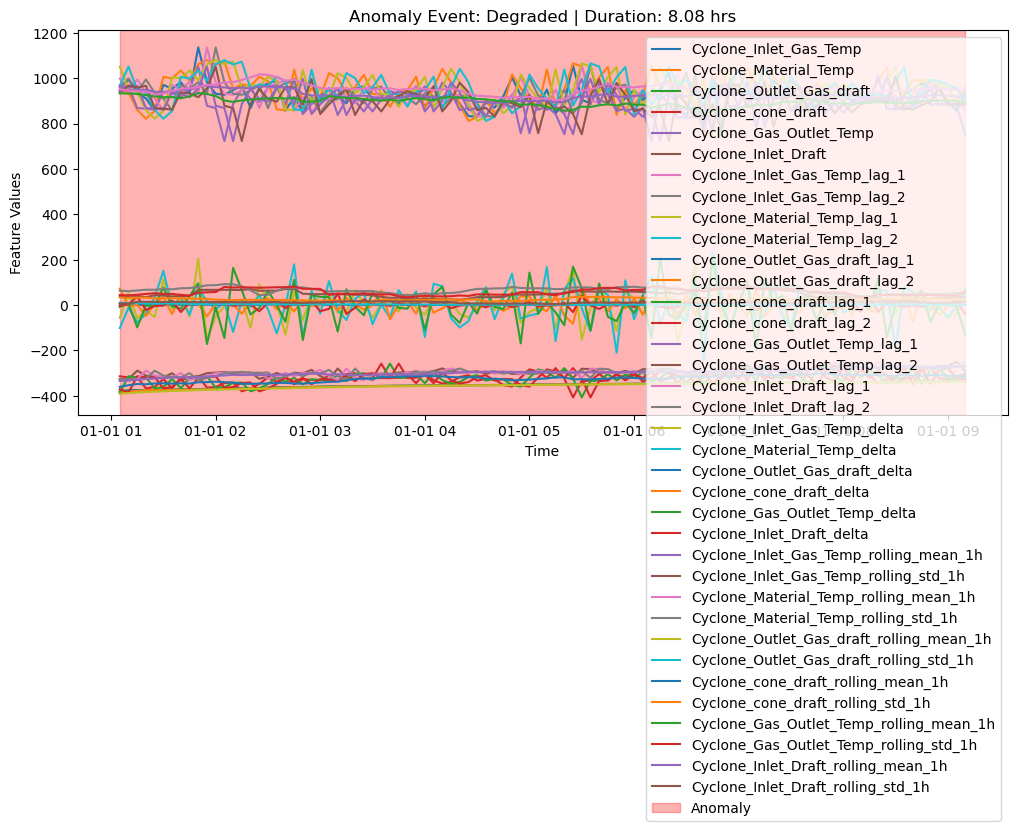

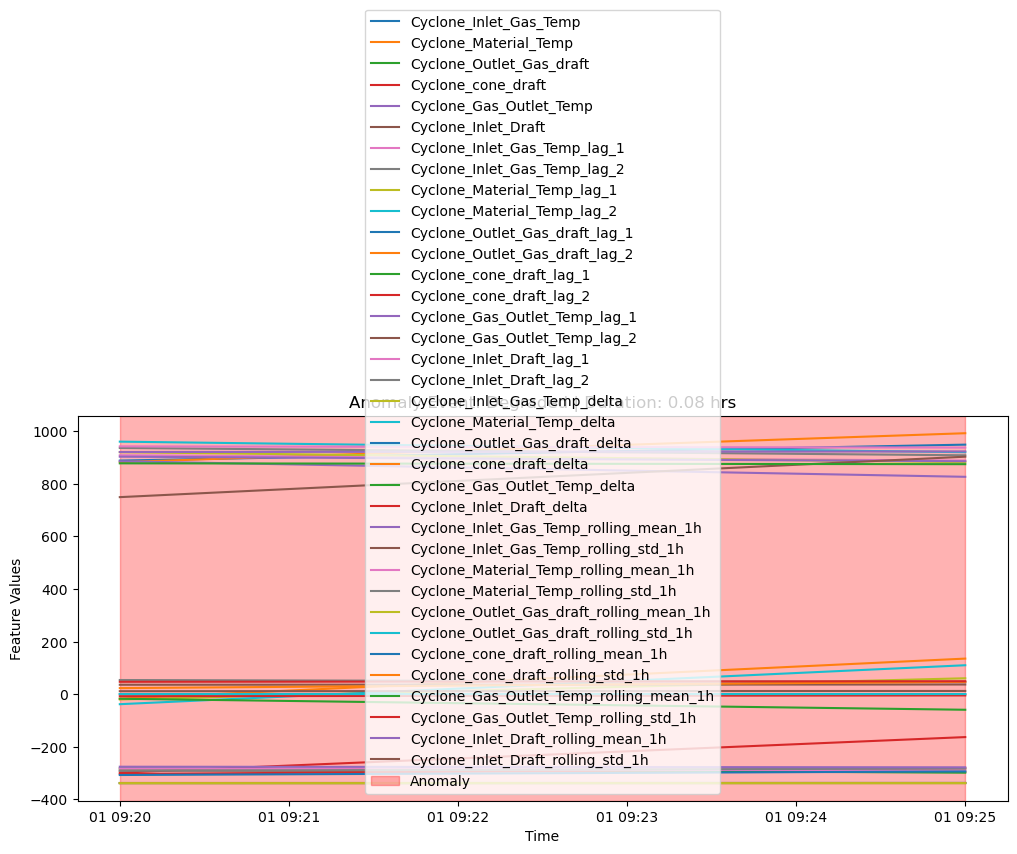

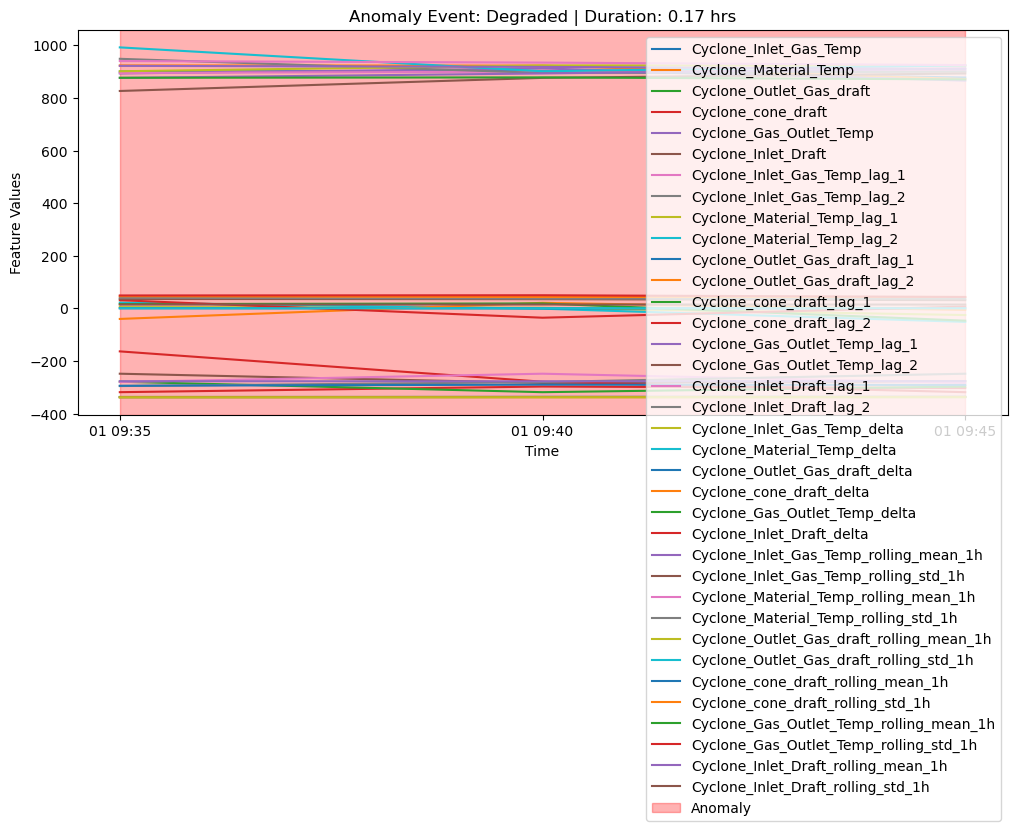

In [56]:
selected_events = events.head(3)  # pick 3 events for illustration

for idx, row in selected_events.iterrows():
    start, end = row['start_time'], row['end_time']
    event_df = df_active[(df_active['time'] >= start) & (df_active['time'] <= end)]
    
    plt.figure(figsize=(12,5))
    for feature in features:
        plt.plot(event_df['time'], event_df[feature], label=feature)
    plt.axvspan(start, end, color='red', alpha=0.3, label='Anomaly')
    plt.title(f"Anomaly Event: {row['state']} | Duration: {row['duration']:.2f} hrs")
    plt.xlabel("Time")
    plt.ylabel("Feature Values")
    plt.legend()
    plt.show()

# 1.5 Short-Horizon Forecasting

For forecasting we will use the data that is free from the shutdowns . We created a new dataframe with only the original features

In [70]:
df_forecast = df_active[['time','Cyclone_Inlet_Gas_Temp','Cyclone_Material_Temp','Cyclone_Outlet_Gas_draft','Cyclone_cone_draft','Cyclone_Gas_Outlet_Temp','Cyclone_Inlet_Draft']]
df_forecast = df_forecast.set_index('time')
df_forecast = df_forecast.sort_index()

Checking the stationarity of the series

In [83]:
def check_stationarity(series, alpha=0.05):
    result = adfuller(series.dropna(), autolag='AIC')
    test_stat, p_value, lags, n_obs, crit_values, icbest = result
    
    print("ADF Statistic:", test_stat)
    print("p-value:", p_value)
    print("Critical Values:", crit_values)
    
    if p_value < alpha:
        print(f" The series is stationary (reject H0 at {alpha} level).")
    else:
        print(f" The series is NOT stationary (fail to reject H0 at {alpha} level).")

check_stationarity(df_forecast["Cyclone_Inlet_Gas_Temp"])

ADF Statistic: -3.6032438887258578
p-value: 0.00569931353655926
Critical Values: {'1%': -3.430370834592288, '5%': -2.8615492086325234, '10%': -2.5667749014208097}
 The series is stationary (reject H0 at 0.05 level).


After checking the data for stationarity we will move to splitting the data into training and testing data

In [72]:
train, test = train_test_split(df_forecast["Cyclone_Inlet_Gas_Temp"], test_size=0.2, shuffle=False)

Now for persistence baseline where we predict the next value using the previous value

In [73]:
persistence_forecast = [train.iloc[-1]] * len(test)

In [76]:
rmse_persistence = np.sqrt(mean_squared_error(test, persistence_forecast))
mae_persistence  = mean_absolute_error(test, persistence_forecast)

print("Persistence Baseline:")
print(f"RMSE = {rmse_persistence:.3f}\nMAE = {mae_persistence:.3f}")

Persistence Baseline:
RMSE = 277.407
MAE = 170.934


Next we would implement the ARIMA model and fit the data 

In [77]:
arima_model = ARIMA(train, order=(2,1,2))
arima_fit = arima_model.fit()

Forecasting using the ARIMA model

In [78]:
arima_forecast = arima_fit.forecast(steps=len(test))

In [80]:
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
mae_arima  = mean_absolute_error(test, arima_forecast)

print("\nARIMA Model:")
print(f"RMSE = {rmse_arima:.3f}\nMAE = {mae_arima:.3f}")


ARIMA Model:
RMSE = 252.621
MAE = 138.187


Upon comparison we can see that ARIMA give better results that the traditional persistence model. So we would use ARIMA model to forecast for the next 12 steps (1 Hour)

In [81]:
short_horizon_forecast = arima_fit.forecast(steps=12)
print("\nNext 12-step forecast (Cyclone_Inlet_Gas_Temp):")
print(short_horizon_forecast)


Next 12-step forecast (Cyclone_Inlet_Gas_Temp):
251168    887.862962
251169    886.282070
251170    886.106472
251171    886.210014
251172    886.107619
251173    886.206263
251174    886.111134
251175    886.202870
251176    886.114406
251177    886.199714
251178    886.117449
251179    886.196780
Name: predicted_mean, dtype: float64


# 1.6 Insights & Storytelling

**Insights :**

Higher Degraded states can be seen in the data

A total of 5567 shutdowns were detected between the span of 3 years and the downtime was approx 221 days 

Cyclone_Inlet_Gas_Temp is highly positively correlated with Cyclone_Material_temp and Cyclone_Gas_outlet_temp but is inversly correlated with Cyclone_inlet_draft , Cyclone_outlet_gas_draft and Cyclone_cone_draft

After removing the shutdowns we got almost 313974 operational states



**Actionable Recommendations:**

While retreiving the data check for I/O Timeouts from the sensor side

Collect additional upstream flow/draft sensors to better explain anomalies.

Label shutdown events explicitly in logs for improved supervised learning.

Implement early-Warning Triggers using real-time anomaly alerts 